In [34]:
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import os
import glob
import random
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow.keras.layers import Input, Conv2D,Dropout, BatchNormalization, Activation, MaxPooling2D, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import tensorflow

In [9]:
extract_dir = 'tb'

with zipfile.ZipFile('archive(28).zip', 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

extracted_files = os.listdir(extract_dir)
print("Extracted files:", extracted_files)

Extracted files: ['TB_Chest_Radiography_Database']


In [10]:
normal_path = 'tb/TB_Chest_Radiography_Database/Normal'
tb_path = 'tb/TB_Chest_Radiography_Database/Tuberculosis'

In [11]:
#Printing images
normal_images = os.listdir(normal_path)
tuberculosis_images = os.listdir(tb_path)

print("Number of normal images:",len(normal_images))
print("Number of tuberculosis images",len(tuberculosis_images))

Number of normal images: 3500
Number of tuberculosis images 700


In [16]:
#shuffling to normalize the order
random.shuffle(normal_images)
random.shuffle(tuberculosis_images)

In [17]:
normal = glob.glob("tb/TB_Chest_Radiography_Database/Normal/*")
tb = glob.glob("tb/TB_Chest_Radiography_Database/Tuberculosis/*")

# Splitting in 70:15:15 ratio 
train_path = normal[:2450] + tb[:490]
val_path = normal[2450:2975] + tb[490:595]
test_path = normal[2975:] + tb[595:]

print("Train X-Ray Images: ",len(train_path))
print("Validation X-Ray Images: ",len(val_path))
print("Test X-Ray Images: ",len(test_path))

Train X-Ray Images:  2940
Validation X-Ray Images:  630
Test X-Ray Images:  630


In [18]:
source_dirs = ["tb/TB_Chest_Radiography_Database/Normal", "tb/TB_Chest_Radiography_Database/Tuberculosis"]
dest_dirs = ["tb/train", "tb/validation", "tb/test"]

# Create destination directories if they don't exist
for dir_path in dest_dirs:
    os.makedirs(dir_path, exist_ok=True)
    os.makedirs(os.path.join(dir_path, 'Normal'), exist_ok=True)
    os.makedirs(os.path.join(dir_path, 'Tuberculosis'), exist_ok=True)

# Move images to train, validation, and test directories
for i, paths in enumerate([train_path, val_path, test_path]):
    for path in paths:
        class_name = "Normal" if "Normal" in path else "Tuberculosis"
        file_name = os.path.basename(path)
        dest_dir = os.path.join(dest_dirs[i], class_name)
        shutil.copy(path, os.path.join(dest_dir, file_name))

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
train_dir = 'tb/train'
validation_dir = 'tb/validation'
test_dir = 'tb/test'

In [24]:
img_height = 224
img_width = 224
batch_size = 32

#Data Generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'  #for 2- binary classification
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)


Found 2940 images belonging to 2 classes.
Found 630 images belonging to 2 classes.
Found 631 images belonging to 2 classes.


In [27]:
from tensorflow.keras import layers, Model

def build_resnet(input_shape=(224, 224, 3)):
    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Initial convolutional layer
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Residual blocks
    for _ in range(3):
        x = residual_block(x, 64)

    for filters in [128, 256, 512]:
        x = residual_block(x, filters, strides=(2, 2))

    # Average pooling layer
    x = layers.GlobalAveragePooling2D()(x)

    # Output layer for binary classification
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(inputs, outputs)
    return model

def residual_block(x, filters, strides=(1, 1)):
    shortcut = x
    x = layers.Conv2D(filters, (3, 3), strides=strides, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Adjust the dimensions of the shortcut to match the dimensions of the residual
    if strides != (1, 1) or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=strides, padding='same', activation='relu')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add the shortcut to the residual
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

# Build the ResNet model
resnet_model = build_resnet()

# Print model summary
resnet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 112, 112, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 56, 56, 64)  0           ['conv2d_16[0][0]']              
                                                                                            

In [28]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
resnet_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define number of epochs
epochs = 10

# Define model checkpoint callback
checkpoint = ModelCheckpoint('resnet_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

# Train the model
history = resnet_model.fit(train_generator,
                            epochs=epochs,
                            steps_per_epoch=len(train_generator),
                            validation_data=validation_generator,
                            validation_steps=len(validation_generator),
                            callbacks=[checkpoint])

Epoch 1/10
92/92 [==============================] - ETA: 0s - loss: 0.2394 - accuracy: 0.9255
Epoch 1: val_accuracy improved from -inf to 0.86984, saving model to resnet_model.h5
92/92 [==============================] - 413s 4s/step - loss: 0.2394 - accuracy: 0.9255 - val_loss: 0.4326 - val_accuracy: 0.8698
Epoch 2/10
92/92 [==============================] - ETA: 0s - loss: 0.1332 - accuracy: 0.9510
Epoch 2: val_accuracy did not improve from 0.86984
92/92 [==============================] - 388s 4s/step - loss: 0.1332 - accuracy: 0.9510 - val_loss: 2.6994 - val_accuracy: 0.2286
Epoch 3/10
92/92 [==============================] - ETA: 0s - loss: 0.1188 - accuracy: 0.9588
Epoch 3: val_accuracy did not improve from 0.86984
92/92 [==============================] - 385s 4s/step - loss: 0.1188 - accuracy: 0.9588 - val_loss: 0.7916 - val_accuracy: 0.7619
Epoch 4/10
92/92 [==============================] - ETA: 0s - loss: 0.1183 - accuracy: 0.9565
Epoch 4: val_accuracy improved from 0.86984 to 

In [37]:
train_loss, train_accuracy = resnet_model.evaluate(train_generator)
print('Train loss:', train_loss)
print('Train accuracy:', train_accuracy)

92/92 [==============================] - 146s 2s/step - loss: 0.5306 - accuracy: 0.8531
Train loss: 0.5306048393249512
Train accuracy: 0.8530611991882324


In [29]:
# Making predictions on the validation set
validation_predictions = resnet_model.predict(validation_generator)
validation_predicted_labels = validation_predictions > 0.5  # Convert probabilities to binary predictions

# Getting the actual labels for the validation set
validation_actual_labels = validation_generator.labels

# Comparing predicted labels with actual labels
from sklearn.metrics import classification_report
print("Validation Classification Report:")
print(classification_report(validation_actual_labels, validation_predicted_labels))

# Make=ing predictions on the test set
test_predictions = resnet_model.predict(test_generator)
test_predicted_labels = test_predictions > 0.5  # Convert probabilities to binary predictions

# Getting the actual labels for the test set
test_actual_labels = test_generator.labels

# Compare predicted labels with actual labels
print("Test Classification Report:")
print(classification_report(test_actual_labels, test_predicted_labels))


20/20 [==============================] - 23s 1s/step
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.77      0.80       525
           1       0.17      0.24      0.20       105

    accuracy                           0.68       630
   macro avg       0.50      0.50      0.50       630
weighted avg       0.72      0.68      0.70       630

20/20 [==============================] - 29s 1s/step
Test Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.75      0.78       526
           1       0.15      0.22      0.18       105

    accuracy                           0.66       631
   macro avg       0.49      0.48      0.48       631
weighted avg       0.71      0.66      0.68       631



In [30]:
# Evaluate the model on the validation set
validation_loss, validation_accuracy = resnet_model.evaluate(validation_generator)
print('Validation loss:', validation_loss)
print('Validation accuracy:', validation_accuracy)

# Evaluate the model on the test set
test_loss, test_accuracy = resnet_model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

20/20 [==============================] - 20s 997ms/step - loss: 0.5446 - accuracy: 0.8444
Validation loss: 0.5445850491523743
Validation accuracy: 0.8444444537162781
20/20 [==============================] - 20s 1s/step - loss: 0.3527 - accuracy: 0.9049
Test loss: 0.35268300771713257
Test accuracy: 0.9049128293991089


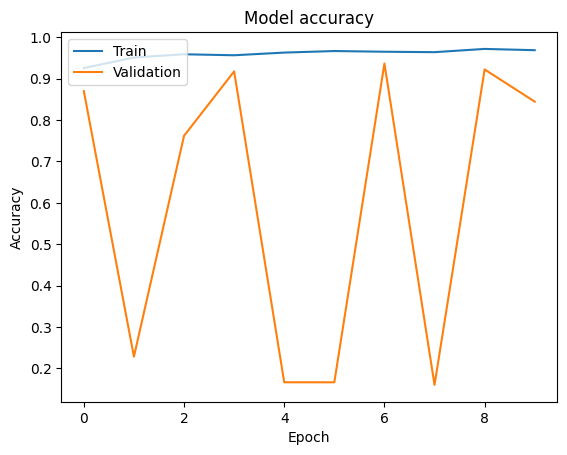

In [31]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

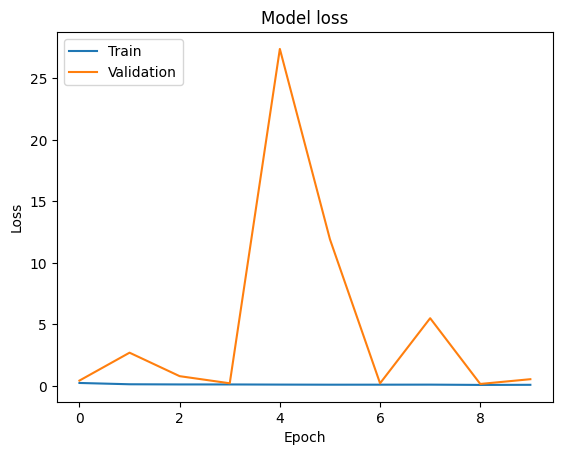

In [32]:
# Plot training & validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [39]:
def build_custom_cnn(input_shape=(224, 224, 3), num_classes=2):
    model = Sequential()
    
    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Additional Convolutional layers for increased complexity
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    
    # Flatten layer
    model.add(Flatten())
    
    # Fully connected layers with increased units
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

# Build the updated custom CNN model
custom_cnn_model = build_custom_cnn(input_shape=(224, 224, 3), num_classes=2)

# Display updated model architecture
custom_cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_36 (Bat  (None, 222, 222, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_39 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_37 (Bat  (None, 109, 109, 64)     256       
 chNormalization)                                                
                                                      

In [40]:
# Compile the model
custom_cnn_model.compile(optimizer=Adam(learning_rate=0.001), 
                         loss='sparse_categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' for integer labels
                         metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint('custom_cnn_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

# Train the model
history = custom_cnn_model.fit(train_generator,
                                epochs=epochs,
                                steps_per_epoch=len(train_generator),
                                validation_data=validation_generator,
                                validation_steps=len(validation_generator),
                                callbacks=[checkpoint])

Epoch 1/10
92/92 [==============================] - ETA: 0s - loss: 3.4645 - accuracy: 0.8881
Epoch 1: val_accuracy improved from -inf to 0.42381, saving model to custom_cnn_model.h5
92/92 [==============================] - 340s 4s/step - loss: 3.4645 - accuracy: 0.8881 - val_loss: 7.1754 - val_accuracy: 0.4238
Epoch 2/10
92/92 [==============================] - ETA: 0s - loss: 2.2659 - accuracy: 0.9133
Epoch 2: val_accuracy did not improve from 0.42381
92/92 [==============================] - 332s 4s/step - loss: 2.2659 - accuracy: 0.9133 - val_loss: 29.3142 - val_accuracy: 0.1667
Epoch 3/10
92/92 [==============================] - ETA: 0s - loss: 1.2234 - accuracy: 0.9310
Epoch 3: val_accuracy improved from 0.42381 to 0.45397, saving model to custom_cnn_model.h5
92/92 [==============================] - 270s 3s/step - loss: 1.2234 - accuracy: 0.9310 - val_loss: 22.5958 - val_accuracy: 0.4540
Epoch 4/10
92/92 [==============================] - ETA: 0s - loss: 0.8945 - accuracy: 0.9272


In [41]:
train_loss1, train_accuracy1 = custom_cnn_model.evaluate(train_generator)
print('Custom Model: ')
print('Train loss:', train_loss1)
print('Train accuracy:', train_accuracy1)

92/92 [==============================] - 157s 2s/step - loss: 0.1837 - accuracy: 0.9306
Custom Model: 
Train loss: 0.1837218552827835
Train accuracy: 0.9306122660636902


In [45]:
from keras.utils import to_categorical
test_actual_labels_binary = to_categorical(test_actual_labels1)

# Compare predicted labels with actual labels
print("Test Classification Report:")
print(classification_report(test_actual_labels_binary, test_predicted_labels1))

Test Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       526
           1       0.14      0.06      0.08       105

   micro avg       0.79      0.79      0.79       631
   macro avg       0.49      0.49      0.48       631
weighted avg       0.72      0.79      0.75       631
 samples avg       0.79      0.79      0.79       631

